In [2]:
%load_ext autoreload
%autoreload 2
from spyglass.ripple.v1 import RippleTimesV1, RippleParameters
from spyglass.common import interval_list_intersect
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.lfp import LFPOutput

import numpy as np
from scipy.stats import ttest_rel

import os
import matplotlib.pyplot as plt

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import OptoStimProtocol
from Analysis.utils import filter_opto_data, violin_scatter
from Style.style_guide import animal_style, interval_style
from AnalysisTables.decoding_tables import ClusterlessAheadBehindDistance

from AnalysisTables.decoding_tables import RippleClusterlessDecodeAnalysisSelection, RippleClusterlessDecodeAnalysis


from spyglass.position.v1 import TrodesPosV1
from spyglass.position.position_merge import PositionOutput
from spyglass.lfp.analysis.v1 import LFPBandV1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Populate

In [4]:
dlc_pos = True
acausal = False

for animal in animal_style.index:
    dataset_key = {"animal": animal, "track_type": "early_wtrack"}
    dataset = filter_opto_data(dataset_key)

    ripple_class = []
    for key in dataset.fetch("KEY"):
        clusterless_key = {
            "nwb_file_name": key["nwb_file_name"],
            "encoding_interval": key["interval_list_name"],
        }
        query = ClusterlessDecodingV1() & clusterless_key
        if dlc_pos:
            query = query & "position_group_name LIKE 'dlc%'"
        else:
            query = query - "position_group_name LIKE 'dlc%'"
        if not query:
            continue
        clusterless_key = query.fetch1("KEY")
        if not ClusterlessAheadBehindDistance() & clusterless_key:
            continue
        query = (
            RippleTimesV1()
            & {
                "nwb_file_name": key["nwb_file_name"],
            }
            & "target_interval_list_name LIKE '%{}%'".format(key["interval_list_name"])
        )
        if dlc_pos:
            query = query & PositionOutput.DLCPosV1().proj(pos_merge_id="merge_id")
        else:
            query & PositionOutput.TrodesPosV1().proj(pos_merge_id="merge_id")

        ripple_key = query.fetch1("KEY")
        analysis_key = {**ripple_key, **clusterless_key, "acausal": acausal}
        RippleClusterlessDecodeAnalysisSelection().insert1(
            analysis_key, skip_duplicates=True
        )

datasets: 9
datasets: 9
datasets: 10
datasets: 16
datasets: 0
datasets: 10
datasets: 8
datasets: 16
datasets: 8


In [6]:
RippleClusterlessDecodeAnalysis().populate(processes=16, suppress_errors=True)

[2024-09-18 13:32:35,110][WARNING]: Skipped checksum for file with hash: 03329964-8979-0d0d-aa61-f50a7df8c486, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_98f5ef2b-4d00-4ed1-a3a1-8e2fb668ab8d.nc
[2024-09-18 13:32:35,109][WARNING]: Skipped checksum for file with hash: b8728e1b-151c-6312-0809-6d6cd6900bd2, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_89e4a112-1e04-4a7e-b65e-01d4093b8431.nc
[2024-09-18 13:32:35,110][WARNING]: Skipped checksum for file with hash: f3ccbe30-c62a-ce67-4b1c-acb2419b9ee4, and path: /stelmo/nwb/analysis/Winnie20220719/Winnie20220719_3cd57781-04fb-4d0b-9663-ccd7d92e0f0a.nc
[2024-09-18 13:32:35,111][WARNING]: Skipped checksum for file with hash: 40ab1332-c908-afc6-07ab-3524c601532c, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_6421c626-0252-4fe5-a87f-8829203d4c4b.nc
[2024-09-18 13:32:35,113][WARNING]: Skipped checksum for file with hash: 0baae3e8-e022-55be-9354-08cb6acbbc5d, and path: /stelmo/nwb/analysis/Yoshi20220518/

[]

# Look at ripple classification

In [7]:
from Style.style_guide import animal_style

results = {}
for animal in animal_style.index:
    # animal = "Yoshi"
    data = RippleClusterlessDecodeAnalysis() & "nwb_file_name LIKE '%{}%'".format(
        animal
    )
    if not data:
        continue
    results[animal] = data.classify_ripple_decode(locality_threshold=40)
    # break

([<matplotlib.axis.XTick at 0x7f23e8e8fcd0>,
 [Text(0, 0, 'Continuous'),
  Text(1, 0, 'Fragmented'),
  Text(2, 0, 'Mixed'),
  Text(3, 0, 'Local')])

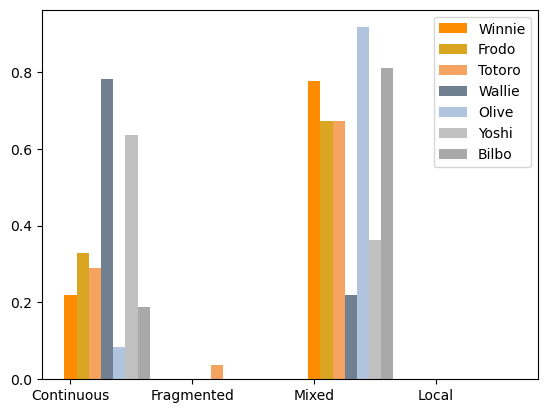

In [8]:
class_names = ["Continuous", "Fragmented", "Mixed", "Local"]
for i, (animal, ripple_class) in enumerate(results.items()):
    width = 0.1
    ripple_class = ripple_class[
        ~np.logical_or(ripple_class == "Local", ripple_class == "NAN")
    ]
    # class_names = np.unique(ripple_class)
    for j, class_name in enumerate(class_names):
        plt.bar(
            j + i * width,
            np.mean([ripple_class_i == class_name for ripple_class_i in ripple_class]),
            width,
            color=animal_style.loc[animal, "color"],
            label=animal if j == 0 else None,
        )
plt.legend()
plt.xticks(range(len(class_names)), class_names)

# ripple time fractions

In [65]:
labels = {}
for animal in animal_style.index:
    data = RippleClusterlessDecodeAnalysis() & "nwb_file_name LIKE '%{}%'".format(
        animal
    )
    if not data:
        continue
    labels[animal] = data.classify_ripple_decode(locality_threshold=40)

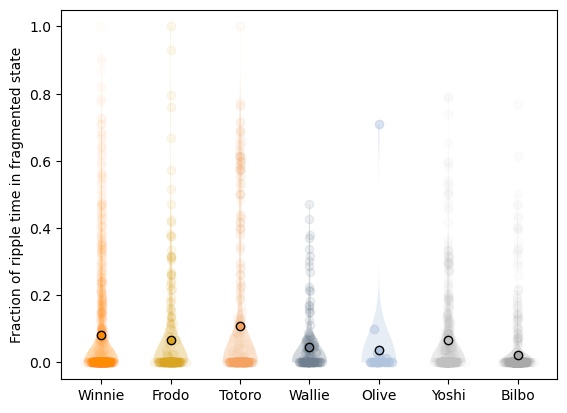

<Figure size 1000x1000 with 0 Axes>

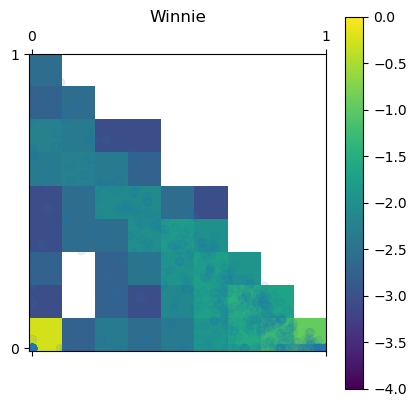

<Figure size 1000x1000 with 0 Axes>

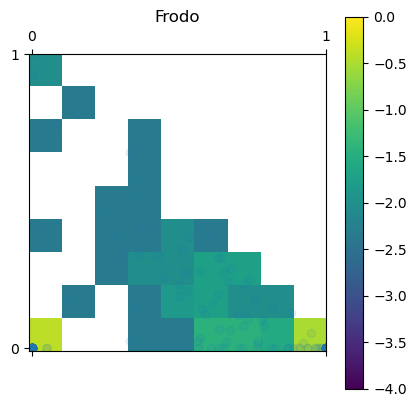

<Figure size 1000x1000 with 0 Axes>

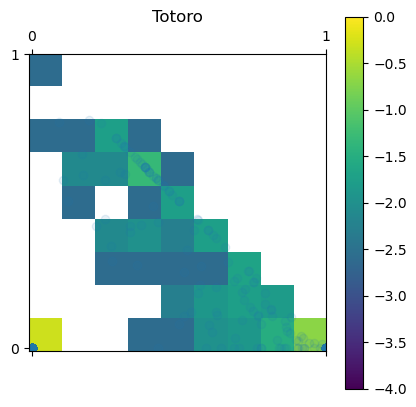

<Figure size 1000x1000 with 0 Axes>

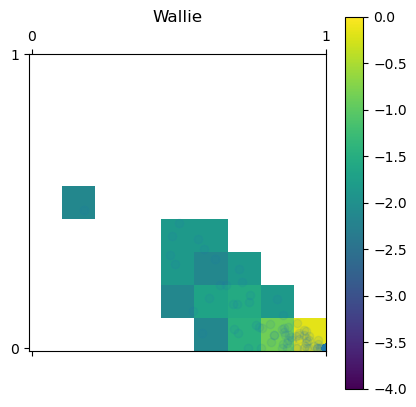

<Figure size 1000x1000 with 0 Axes>

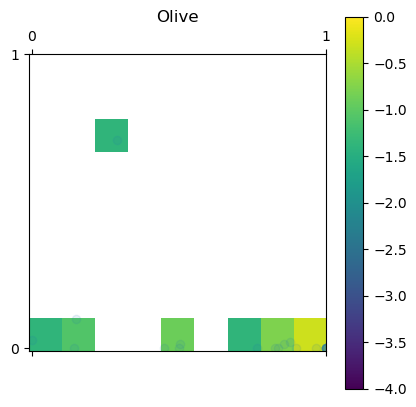

<Figure size 1000x1000 with 0 Axes>

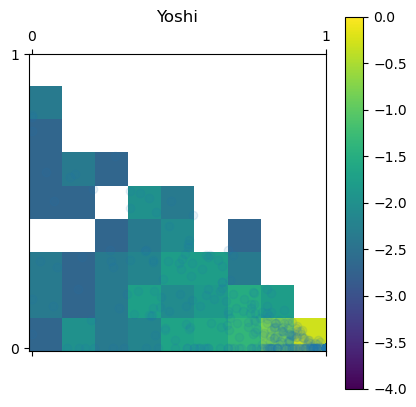

<Figure size 1000x1000 with 0 Axes>

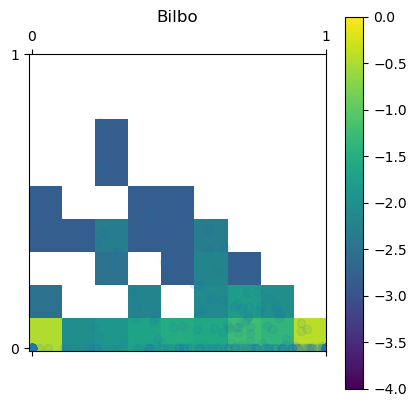

In [84]:
state_thresh = 0.6
exclude_labels = ["Local", "NAN"]
combine_fig = plt.figure()
ax_combine = combine_fig.add_subplot(111)
loc = 0
plotted = []
for i,animal in enumerate(animal_style.index):
    # animal = "Winnie"
    data = RippleClusterlessDecodeAnalysis() & "nwb_file_name LIKE '%{}%'".format(
        animal
    )
    if not data:
        continue


    data = data.fetch_dataframe()
    # break
    fig = plt.figure(figsize=(10, 10))
    state_fracs = np.array(
        [np.mean(x > state_thresh, axis=0) for x in data.state_posterior.values]
    )
    label_filer = np.array([x not in exclude_labels for x in labels[animal]])
    state_fracs = state_fracs[label_filer]

    H, xedges, yedges = np.histogram2d(
        state_fracs[:, 1], state_fracs[:, 0], bins=np.linspace(-0.01, 1, 10)
    )

    H = H / H.sum()
    H = np.log10(H)
    plt.matshow(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower",clim=[-4, 0])
    plt.colorbar()

    plt.scatter(state_fracs[:, 0], state_fracs[:, 1], alpha=0.1)
    plt.title(animal)

    violin_scatter(
        state_fracs[:, 1],
        ax=ax_combine,
        pos = loc,
        color=animal_style.loc[animal, "color"],
    )
    ax_combine.scatter([loc], [np.mean(state_fracs[:, 1])], color=animal_style.loc[animal, "color"],edgecolor='k')
    loc+=1
    plotted.append(animal)
    # break
ax_combine.set_ylabel("Fraction of ripple time in fragmented state")
ax_combine.set_xticks(range(len(plotted)), plotted)


# Plot examples

In [157]:
animal = "Yoshi"
data = RippleClusterlessDecodeAnalysis() & "nwb_file_name LIKE '%{}%'".format(animal)
data_df = data.fetch_dataframe()

In [160]:
for i in np.random.choice(len(data_df),10):

    data = data_df.iloc[i]



    y_max = np.max([np.max(x) for x in data_df.position.values])

    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 10))
    t_decode = np.linspace(data.interval[0], data.interval[1], data.state_posterior.shape[0])
    ax[-1].imshow(
        data.pos_posterior.T,
        cmap="bone_r",
        extent=[
            t_decode[0],
            t_decode[-1],
            0,
            y_max,
        ],
        aspect="auto",
        clim=(0, 0.05),
        origin="lower",
    )
    print(y_max)
    print(data.position)
    ax[-1].plot(t_decode,data.position, c="pink",lw=4)
    ax[-1].set_ylim(-3, y_max+3)

    t_ripple = np.linspace(data.interval[0], data.interval[1], data.ripple_band.shape[0])
    ax[0].plot(t_ripple,data.ripple_band, c="grey", alpha=0.5)


    ax[1].plot(t_decode,data.state_posterior)



458.91033281270063
[1.46066446 1.46075311 1.46084176 1.46093041 1.46101906 1.46110771
 1.46119636 1.46128501 1.46170459 1.46203552 1.46236645 1.46269737
 1.4630283  1.46335923 1.46369016 1.46402109 1.46435202 1.46468295
 1.46501388 1.46534481 1.46567574 1.46600667 1.4663376  1.46666853
 1.46699946 1.46670335 1.4660763  1.46544926 1.46482221 1.46419517
 1.46356812 1.46294108 1.46231404 1.46168699 1.46105995]
458.91033281270063
[458.91033281 458.91033281 458.91033281 458.91033281 458.91033281
 458.91033281 458.91033281 458.91033281 458.91033281 458.91033281
 458.91033281 458.91033281 458.91033281 458.91033281 458.91033281
 458.91033281 458.91033281 458.91033281 458.91033281 458.91033281
 458.91033281 458.91033281 458.91033281 458.91033281 458.91033281
 458.91033281 458.91033281]
458.91033281270063
[0.75879549 0.7518707  0.74494592 0.73802113 0.73109634 0.72417155
 0.70903446 0.70082216 0.69260986 0.68439756 0.67618526 0.66797295
 0.65976065 0.65154835 0.64333605 0.63512375 0.62691144 0.6

In [155]:
# data_df.iloc[10], y_max
np.random.choice(100,10)

array([96,  3, 56, 26, 61, 99, 25, 43, 41, 53])

In [132]:
np.max([np.max(x) for x in data_df.position.values])

458.91033281270063

In [ ]:
i = np.where(np.array(ripple_class) == "undefined")[0][7]
# i = 8
samples = np.where(np.array(ripple_class) == "undefined")[0][:10]
samples = np.random.choice(np.arange(len(ripple_intervals)), 10)
samples = -np.arange(8)

for i in samples:
    interval = ripple_intervals[i]
    print(interval[1] - interval[0])
    window_pad = 0.05  # 0.02 * 3

    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 10))
    plot_post = posterior.sel(
        time=slice(interval[0] - window_pad, interval[1] + window_pad),
    )

    ax[-1].imshow(
        plot_post.T,
        cmap="bone_r",
        extent=[
            plot_post.time.min(),
            plot_post.time.max(),
            0,
            np.nanmax(linear_df.linear_position.values),
        ],
        aspect="auto",
        clim=(0, 0.05),
    )
    ax[-1].plot(linear_df.index, linear_df.linear_position.values, c="pink")

    # ind = np.logical_and(
    #     lfp_df.index > interval[0] - window_pad, lfp_df.index < interval[1] + window_pad
    # )
    # plot_lfp = lfp_df.values[ind, :30]
    # plot_lfp = plot_lfp / np.max(np.abs(plot_lfp))
    # plot_lfp = plot_lfp + np.arange(30) / 2
    # ax[0].plot(lfp_df.index[ind], plot_lfp, c="grey", alpha=0.5)
    ind = np.logical_and(
        band_df.index > interval[0] - window_pad,
        band_df.index < interval[1] + window_pad,
    )
    plot_lfp = band_df.values[ind, :30]
    plot_lfp = plot_lfp / np.max(np.abs(plot_lfp))
    plot_lfp = plot_lfp + np.arange(30) / 2
    ax[0].plot(band_df.index[ind], plot_lfp, c="grey", alpha=0.5)

    val = state_posterior.sel(
        time=slice(interval[0] - window_pad, interval[1] + window_pad)
    )
    ax[1].plot(val.time, val.values)

    for a in ax:
        a.axvline(interval[0], color="r")
        a.axvline(interval[1], color="r")

    fig.suptitle(f"Ripple {i}, class: {ripple_class[i]}")
    ax[-1].set_xlim(interval[0] - window_pad, interval[1] + window_pad)
    ax[-1].set_ylim(-10, np.nanmax(linear_df.linear_position.values) + 10)

In [25]:
from spyglass.common import Session
from spyglass.common import BrainRegion

# %timeit Session() & "nwb_file_name LIKE '%{}%'".format(animal)
%timeit BrainRegion() & "region_name LIKE '%CA1%'"
z
# Session & "nwb_file_name LIKE '%{}%'".format(animal)

3.92 ms ± 71.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
128*32*3.92/1000 * 50

802.816

# Dev

In [35]:
from Style.style_guide import animal_style

results = {}
for animal in animal_style.index:
    animal = "Yoshi"
    data = RippleClusterlessDecodeAnalysis() & "nwb_file_name LIKE '%{}%'".format(
        animal
    )
    if not data:
        continue
    data_df = data.fetch_dataframe()
    break

(0.0, 40.0)

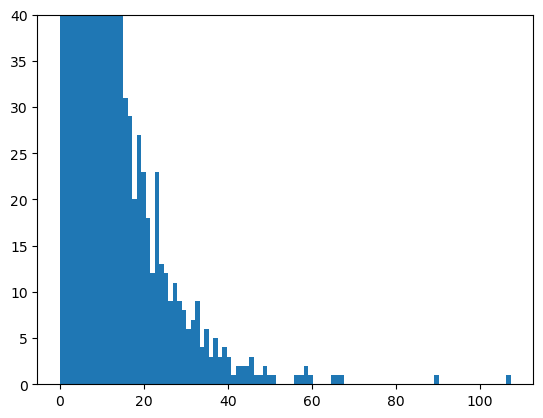

In [40]:
pos = data_df.decode_position.values[0]

from Analysis.utils import smooth

speed_dist = []
for pos in data_df.decode_position.values:
    speed = smooth(np.diff(pos, axis=0), 3)
    speed = np.abs(speed)
    speed_dist.append(np.mean(speed))

plt.hist(speed_dist, bins=100)
plt.ylim(0, 40)